In [168]:
import pandas as pd
import numpy as np
import datetime

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

In [169]:
%matplotlib inline

# load data

In [170]:
START_DATE = '2021-11-30'

In [171]:
# form status
q = "select id, status from form"
all_forms = redshift_query_read(q, schema='production')
active_forms = all_forms[all_forms['status']==1]['id'].tolist()

In [172]:
print("{:,} forms".format(len(all_forms)))
print("{:,} forms with active status".format(len(active_forms)))

63,653 forms
28,256 forms with active status


### embeds

In [173]:
# embeds
q = "select widget as form, date from embed"
embeds = redshift_query_read(q, schema='production')
embeds['date'] = pd.to_datetime(embeds['date'])

In [174]:
def is_embed(r):
    if r['form'] in embeds['form'].unique().tolist():
        return True
    return False

### form upgrades

In [175]:
# logged upgrades
q = "select * from syslog_logs where message like '%Qgiv Form Template Upgraded%'"
form_upgrades = redshift_query_read(q, schema="production")[['org', 'form', 'created']]
forms_upgrades_ids_logged = form_upgrades['form'].unique().tolist()

In [176]:
print("first form upgrade: {}".format(form_upgrades['created'].min()))
print("last form upgrade: {}".format(form_upgrades['created'].max()))

first form upgrade: 2020-12-09 15:30:17
last form upgrade: 2021-11-30 17:54:15


In [177]:
# created new template forms
bucket = "qgiv-stats-data"
new_form_template_list = "form_download.csv"
new_forms = get_dataframe_from_file(bucket, new_form_template_list)

new_forms['Go Live Date'] = pd.to_datetime(new_forms['Go Live Date'])

new_forms = new_forms[~new_forms['Form ID'].isin(forms_upgrades_ids_logged)]
new_forms = new_forms[(new_forms['Status']=='active')&(new_forms['Go Live Date']>=START_DATE)]
new_forms_ids = new_forms['Form ID'].unique().tolist()

In [178]:
print("{:,} forms upgraded (noted in logs)".format(len(forms_upgrades_ids_logged)))
print("{:,} forms with new template (production export)".format(len(new_forms)))
print("{:,} forms with new template and active status (production export)".format(len(new_forms_ids)))
print()
print("{:,} new template forms & active".format(len([f for f in set(forms_upgrades_ids_logged + new_forms_ids) if f in active_forms])))
print("\n\nlog entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset")

10,912 forms upgraded (noted in logs)
67 forms with new template (production export)
67 forms with new template and active status (production export)

9,361 new template forms & active


log entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset


Last run:
- 2,740 forms upgraded (noted in logs)
- 7,116 forms with new template (production export)
- 5,154 forms with new template and active status (production export)

- 6,050 new template forms intersection

In [179]:
form_upgrades['month'] = form_upgrades['created'].dt.to_period('M')
form_upgrades['active'] = form_upgrades['form'].isin(active_forms)
monthly_upgrades = form_upgrades.groupby(['month', 'active'])['form'].nunique().reset_index()
monthly_upgrades = monthly_upgrades.pivot(index='month', columns='active', values='form').reset_index()
monthly_upgrades.columns = ['month', 'not active', 'active']

print("template conversions")
monthly_upgrades

template conversions


,month,not active,active
0,2020-12,42,171
1,2021-01,219,277
2,2021-02,149,279
3,2021-03,143,312
4,2021-04,117,249
5,2021-05,116,216
6,2021-06,93,244
7,2021-07,115,241
8,2021-08,78,225
9,2021-09,251,3828


In [180]:
new_forms['month'] = new_forms['Go Live Date'].dt.to_period('m')

print("created new template forms")
new_forms.groupby('month')['Form ID'].count().reset_index()

created new template forms


,month,Form ID
0,2021-11,40
1,2021-12,27


In [181]:
def is_new_template(daily_row):
    try:
        # check for log conversion
        if daily_row['form'] in form_upgrades['form'].unique().tolist():
            # is date after logged upgrade date?
            return daily_row['date'] >= form_upgrades[form_upgrades['form']==daily_row['form']]['created'].iloc[0]
        else:
            # form created as new form template
            return daily_row['form'] in new_forms_ids
    except:
        print("error with form {}".format(daily_row['form']))
        raise Exception

### transactions

In [182]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(START_DATE), schema='production')
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

In [183]:
print("{:,} transactions, {:,} unique".format(len(trans_onetime), len(trans_onetime['id'].unique())))
print("{:,} forms".format(len(trans_onetime['form'].unique())))

26,381 transactions, 26,381 unique
2,285 forms


In [184]:
q_trans_rec = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring!=0 and
                        (source='don_form' or source='mobile')'''
trans_rec = redshift_query_read(q_trans_rec.format(START_DATE), schema='production')
trans_rec['is_recurring'] = True

trans_rec = trans_rec[trans_rec['id']!=12774333]

In [185]:
print("{:,} recurring transactions, {:,} unique".format(len(trans_rec), len(trans_rec['id'].unique())))
print("{:,} forms".format(len(trans_rec['form'].unique())))

14,185 recurring transactions, 14,185 unique
2,256 forms


In [186]:
trans = trans_onetime.append(trans_rec)

In [187]:
print("forms: {:,}".format(trans['form'].nunique()))
print("transactions: {:,}, {:,} unique".format(len(trans), trans['id'].nunique()))
print("one time transactions: {:,}, {:,} unique".format(len(trans[~trans['is_recurring']]), trans[~trans['is_recurring']]['id'].nunique()))
print("recurring transactions: {:,}, {:,} unique".format(len(trans[trans['is_recurring']]), trans[trans['is_recurring']]['id'].nunique()))

forms: 3,657
transactions: 40,566, 40,566 unique
one time transactions: 26,381, 26,381 unique
recurring transactions: 14,185, 14,185 unique


In [188]:
trans['date'].min(), trans['date'].max()

(Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-01 00:00:00'))

### traffic

In [189]:
q_ga = '''select
                date,
                form,
                devicecategory,
                views,
                bounces
            from googleanalytics_traffic
            where
                date>='{}' and
                (qgiv_frontend=1 or p2p_frontend=1) and
                path not like '%/receipt/%' '''
traffic = redshift_query_read(q_ga.format(START_DATE), schema='production')

In [190]:
traffic = traffic.drop_duplicates()

In [191]:
print("{:,} entries; {:,} unique".format(len(traffic), len(traffic.drop_duplicates())))
print("{:,.2f} entries per form".format(traffic.groupby('form')['views'].count().mean()))
print("{:,.2f} observation dates per form".format(traffic.groupby('form')['date'].nunique().mean()))
print("{:,.2f} views per form".format(traffic.groupby('form')['views'].sum().mean()))
print("{:,.2f} views per form per day".format(traffic.groupby(['form', 'date'])['views'].sum().mean()))

67,942 entries; 67,942 unique
11.61 entries per form
3.64 observation dates per form
118.41 views per form
32.49 views per form per day


In [192]:
traffic['date'].min(), traffic['date'].max()

(Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-05 00:00:00'))

### merge & compile data

In [193]:
# limit to active forms
#trans = trans[trans['form'].isin(active_forms)]
#traffic = traffic[traffic['form'].isin(active_forms)]

In [194]:
trans['is new template'] = trans[['form', 'date']].apply(is_new_template, axis=1)

In [195]:
trans['is embed'] = trans['form'].isin(embeds['form'].tolist())

In [196]:
trans_all = trans.copy()

trans_onetime = trans[~trans['is_recurring']]
trans_rec = trans[trans['is_recurring']]
trans_rec = trans_rec.groupby('recurring').first().reset_index()

trans = trans_onetime.append(trans_rec)

In [197]:
print("All transactions: {:,} ({:,} unique)".format(len(trans_all), len(trans_all['id'].unique())))
print("One time and originating recurring: {:,}".format(len(trans)))
print()
print("Trans per form: {:,.2f}".format(trans.groupby('form')['amount'].count().mean()))
print("Trans per form per day: {:,.2f}".format(trans.groupby(['form', 'date'])['amount'].count().mean()))
print("One time trans per form: {:,.2f}".format(trans[~trans['is_recurring']].groupby('form')['amount'].count().mean()))
print("Recurring trans per form: {:,.2f}".format(trans[trans['is_recurring']].groupby('form')['amount'].count().mean()))

All transactions: 40,566 (40,566 unique)
One time and originating recurring: 39,877

Trans per form: 10.90
Trans per form per day: 7.93
One time trans per form: 11.55
Recurring trans per form: 5.98


prior run:
- All transactions: 5,394,447 (5,394,447 unique)
- One time and originating recurring: 3,407,805


- Trans per form: 237.38
- Trans per form per day: 3.15
- One time trans per form: 227.28
- Recurring trans per form: 33.49

#### daily (all devices) data

In [198]:
traffic_agg.columns, len(traffic)

(Index(['date', 'form'], dtype='object'), 67942)

In [199]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [200]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 5,952
daily traffic agg len: 21,323
merged dailies len: 21,159


In [201]:
print("{:,} forms in transaction aggregates".format(len(daily_trans['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies['form'].unique())))
print()

print("2021-07-22:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-07-22']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-07-22')&(trans['recurring']==0)])))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-07-22')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-07-22']['trans_count_onetime'].sum()))
print()

print("2021-05-29:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-05-29']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-05-29')&(trans['recurring']==0)]['id'].unique())))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-05-29')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-05-29']['trans_count_onetime'].sum()))
print()

print("Dailies w/ > 0 transactions and 0 pageviews:")
print("-"*40)
print("{:,} total dailies entries".format(len(dailies)))
print("{:,} entries".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)])))
print("{:,} forms".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)]['form'].unique())))

3,657 forms in transaction aggregates
5,851 forms in traffic aggregates
5,818 forms in merged dailies

2021-07-22:
----------------------------------------
0 forms in transaction aggregates
0 forms in traffic aggregates
0 forms in merged dailies

0 one time transactions from transactions data
0.0 one time transactions from transactions aggregated data
0.0 forms in merged dailies

2021-05-29:
----------------------------------------
0 forms in transaction aggregates
0 forms in traffic aggregates
0 forms in merged dailies

0 one time transactions from transactions data
0.0 one time transactions from transactions aggregated data
0.0 forms in merged dailies

Dailies w/ > 0 transactions and 0 pageviews:
----------------------------------------
21,159 total dailies entries
0 entries
0 forms


In [202]:
dailies['conversion'] = (dailies['trans_count_onetime'] + dailies['trans_count_recurring']) / dailies['views']
dailies['conversion_onetime'] = dailies['trans_count_onetime'] / dailies['views']
dailies['conversion_recurring'] = dailies['trans_count_recurring'] / dailies['views']

In [203]:
# removing outliers
dailies = dailies[dailies['conversion']<1.]

In [204]:
dailies = dailies[dailies['date']>=START_DATE]

In [205]:
# limiting to prior report range
dailies = dailies[dailies['date']<'2021-12-01']

In [206]:
# need to tag embed & new template by prior entries for 0 transaction days
dailies['is new template'] = dailies[['form', 'date']].apply(is_new_template, axis=1)

In [207]:
dailies['is embed'] = dailies['form'].isin(embeds['form'].tolist())

In [208]:
count_new_template_onetime = dailies[dailies['is new template']]['trans_count_onetime'].sum()
count_new_template_rec = dailies[dailies['is new template']]['trans_count_recurring'].sum()
count_old_template_onetime = dailies[~dailies['is new template']]['trans_count_onetime'].sum()
count_old_template_rec = dailies[~dailies['is new template']]['trans_count_recurring'].sum()
count_new_template = count_new_template_onetime + count_new_template_rec
count_old_template = count_old_template_onetime + count_old_template_rec

perc_new_template_onetime = (count_new_template_onetime / (count_new_template_onetime + count_old_template_onetime)) * 100.
perc_new_template_rec = (count_new_template_rec / (count_new_template_rec + count_old_template_rec)) * 100.
perc_new_template = (count_new_template / (count_new_template + count_old_template)) * 100.

print("{:,} daily aggregate observations old template".format(len(dailies[~dailies['is new template']])))
print("{:,} daily aggregate observations new template".format(len(dailies[dailies['is new template']])))
print()
print("{:,} ({:.2f}%) transactions new template".format(count_new_template, perc_new_template))
print("{:,} ({:.2f}%) onetime transactions new template".format(count_new_template_onetime, perc_new_template_onetime))
print("{:,} ({:.2f}%) recurring transactions new template".format(count_new_template_rec, perc_new_template_rec))

2,641 daily aggregate observations old template
1,020 daily aggregate observations new template

2,505.0 (18.62%) transactions new template
2,139.0 (18.09%) onetime transactions new template
366.0 (22.44%) recurring transactions new template


In [209]:
dailies['date'].min(), dailies['date'].max()

(Timestamp('2021-11-30 00:00:00'), Timestamp('2021-11-30 00:00:00'))

# exploration

In [210]:
len_old_temp_zero_conv = len(dailies[(~dailies['is new template'])&(dailies['conversion']==0.0)])
perc_old_temp_zero_conv = (len_old_temp_zero_conv / len(dailies[~dailies['is new template']])) * 100.

len_new_temp_zero_conv = len(dailies[(dailies['is new template'])&(dailies['conversion']==0.0)])
perc_new_temp_zero_conv = (len_new_temp_zero_conv / len(dailies[dailies['is new template']])) * 100.

print("{:,} ({:.2f}%) old template observations w/ 0% conversion".format(len_old_temp_zero_conv, perc_old_temp_zero_conv))
print("{:,} ({:.2f}%) new template observations w/ 0% conversion".format(len_new_temp_zero_conv, perc_new_temp_zero_conv))

2,070 (78.38%) old template observations w/ 0% conversion
657 (64.41%) new template observations w/ 0% conversion


In [211]:
template_date_counts = dailies.groupby(['date', 'is new template'])['conversion'].count().reset_index()
template_date_counts = template_date_counts.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_counts.columns = ['date', 'old template', 'new template']

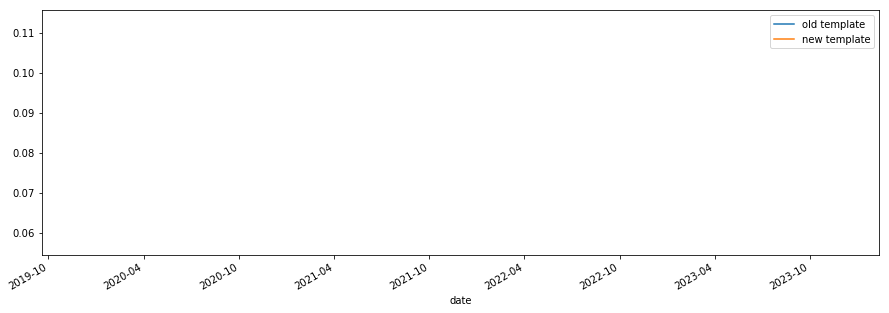

In [212]:
template_date_conv = dailies.groupby(['date', 'is new template'])['conversion'].mean().reset_index()
template_date_conv = template_date_conv.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_conv.columns = ['date', 'old template', 'new template']
template_date_conv.plot(x='date', figsize=(15,5))

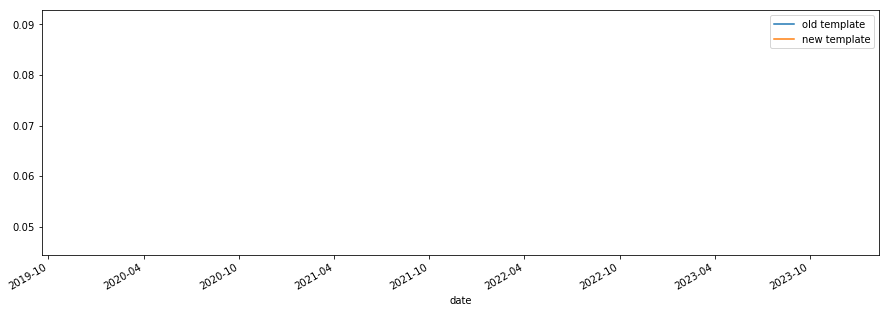

In [213]:
temp_ot_date_conv = dailies.groupby(['date', 'is new template'])['conversion_onetime'].mean().reset_index()
temp_ot_date_conv = temp_ot_date_conv.pivot(index='date', columns='is new template', values='conversion_onetime').reset_index()
temp_ot_date_conv.columns = ['date', 'old template', 'new template']
temp_ot_date_conv.plot(x='date', figsize=(15,5))

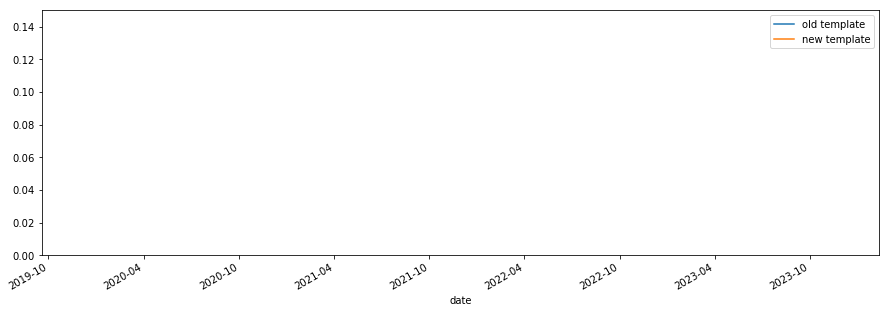

In [214]:
temp_ot_date_conv.plot(x='date', figsize=(15,5), ylim=(0,0.15))

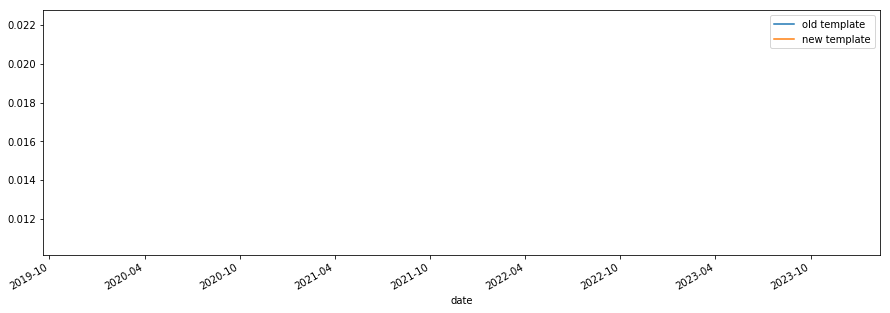

In [215]:
temp_rec_date_conv = dailies.groupby(['date', 'is new template'])['conversion_recurring'].mean().reset_index()
temp_rec_date_conv = temp_rec_date_conv.pivot(index='date', columns='is new template', values='conversion_recurring').reset_index()
temp_rec_date_conv.columns = ['date', 'old template', 'new template']
temp_rec_date_conv.plot(x='date', figsize=(15,5))

In [216]:
dailies[dailies['is new template']].sort_values('conversion_recurring', ascending=False).head()

,date,form,views,bounces,is new template,is embed,trans_count_onetime,trans_count_recurring,trans_vol_onetime,trans_vol_recurring,conversion,conversion_onetime,conversion_recurring
1794,2021-11-30,947632,8.0,0.0,True,True,0.0,6.0,0.0,810.00,0.750000,0.000000,0.750000
2964,2021-11-30,971032,3.0,0.0,True,True,0.0,2.0,0.0,65.00,0.666667,0.000000,0.666667
2062,2021-11-30,953032,3.0,0.0,True,False,0.0,2.0,0.0,67.60,0.666667,0.000000,0.666667
2890,2021-11-30,969541,3.0,0.0,True,True,0.0,2.0,0.0,262.37,0.666667,0.000000,0.666667
496,2021-11-30,749636,11.0,0.0,True,True,2.0,7.0,416.0,385.40,0.818182,0.181818,0.636364


In [217]:
len(dailies), len(dailies[dailies['conversion']>1.]), "{:.2f}%".format((len(dailies[dailies['conversion']>1.]) / len(dailies)) * 100.)

(3661, 0, '0.00%')

In [218]:
over_conv_forms = dailies[dailies['conversion']>1.]['form'].unique().tolist()
intersect_over_conv = [f for f in over_conv_forms if f in dailies[dailies['conversion']<1.]['form'].unique()]

print("{:,} forms w/ > 100% conversion".format(len(over_conv_forms)))
print("{:,} forms overlap w/ < 100% conversion".format(len(intersect_over_conv)))

0 forms w/ > 100% conversion
0 forms overlap w/ < 100% conversion


In [219]:
print(len(dailies[dailies['conversion_onetime']>1.]), len(dailies[dailies['conversion_recurring']>1.]))
print("one time: {:.2f}%".format((len(dailies[dailies['conversion_onetime']>1.]) / len(dailies)) * 100.))
print("recurring: {:.2f}%".format((len(dailies[dailies['conversion_recurring']>1.]) / len(dailies)) * 100.))

0 0
one time: 0.00%
recurring: 0.00%


In [220]:
print("total: {:,}".format(len(dailies[dailies['conversion']>1.])))
print("new template: {:,}".format(len(dailies[(dailies['is new template'])&(dailies['conversion']>1.)])))
print("old template: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is new template'])])))
print("embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(dailies['is embed'])])))
print("not embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is embed'])])))

print()
print("old template & embed: {:,}".format(len(dailies[(~dailies['is new template'])&(dailies['is embed'])&(dailies['conversion']>1.)])))

total: 0
new template: 0
old template: 0
embed: 0
not embed: 0

old template & embed: 0


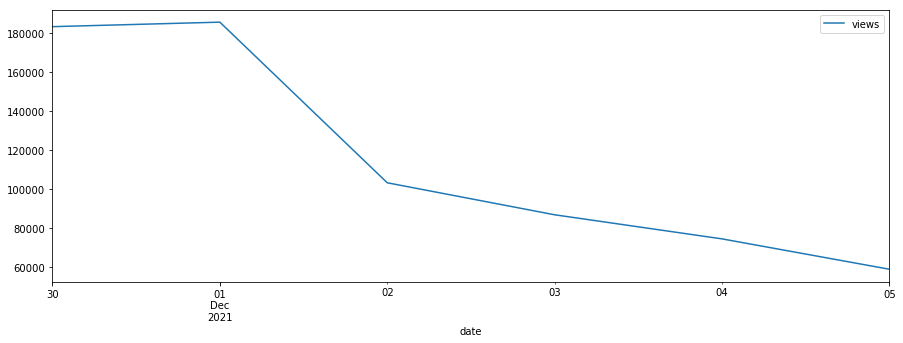

In [221]:
traff_date = traffic.groupby('date')['views'].sum().reset_index()
traff_date.plot(x='date', figsize=(15,5))

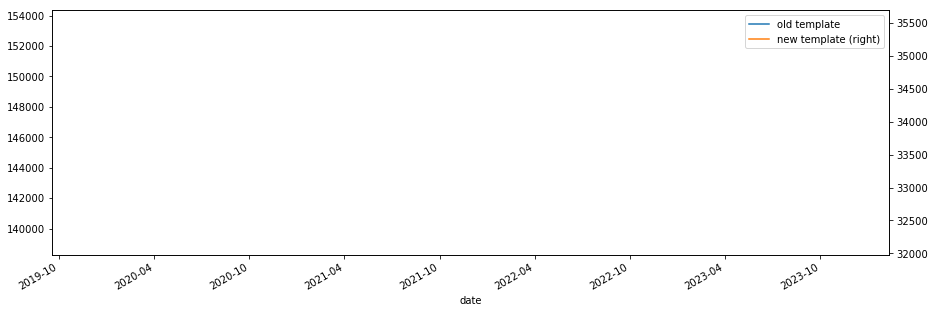

In [222]:
template_date_traf = dailies.groupby(['date', 'is new template'])['views'].sum().reset_index()
template_date_traf = template_date_traf.pivot(index='date', columns='is new template', values='views').reset_index()
template_date_traf.columns = ['date', 'old template', 'new template']
template_date_traf.plot(x='date', secondary_y='new template', figsize=(15,5))

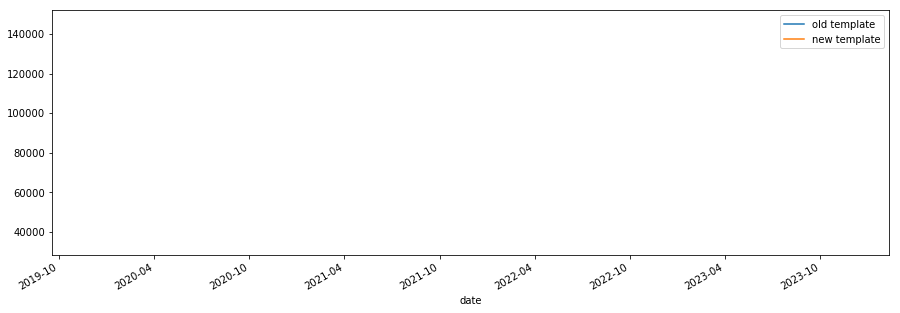

In [223]:
template_date_traf.plot(x='date', figsize=(15,5))

In [224]:
dailies['trans_count'] = dailies['trans_count_onetime'] + dailies['trans_count_recurring']

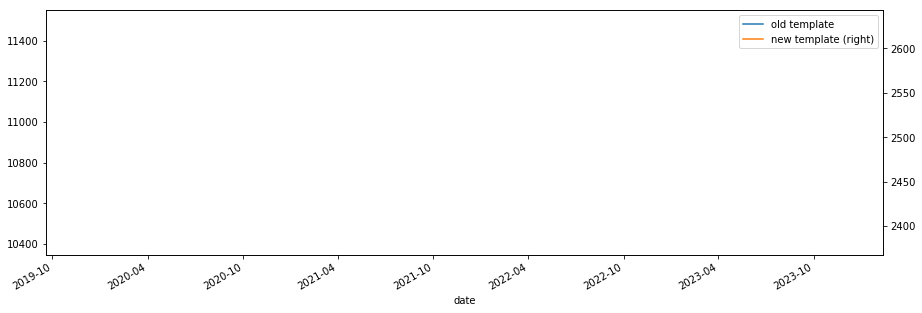

In [225]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_count'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_count').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [226]:
dailies['trans_vol'] = dailies['trans_vol_onetime'] + dailies['trans_vol_recurring']

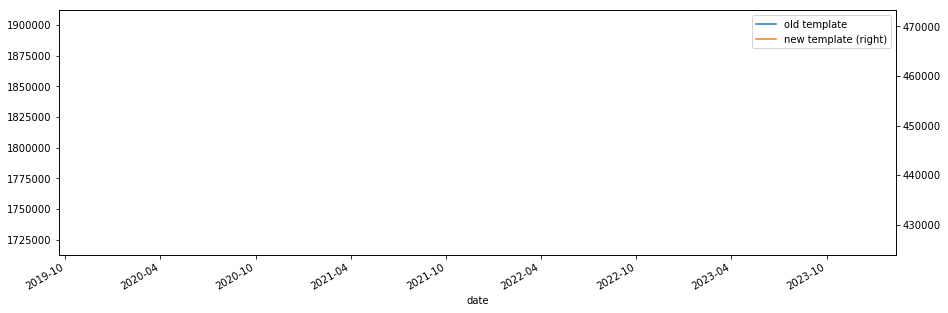

In [227]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_vol'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_vol').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [228]:
template_date_trans.iloc[-28:-23]

,date,old template,new template


_Re: new template spike on 10-04, secure reports for donation form processing shows a similar spike so it appears legit_

#### monthly median transactions

In [229]:
trans['month'] = trans['date'].dt.to_period('M')
trans_monthly_median = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].agg({'median', 'count'}).reset_index()

In [230]:
monthly_medians = trans_monthly_median.pivot(index='month', columns='is new template', values=['count', 'median']).reset_index()
monthly_medians.columns = ['month', 'old template count', 'new template count', 'old template median', 'new template median']

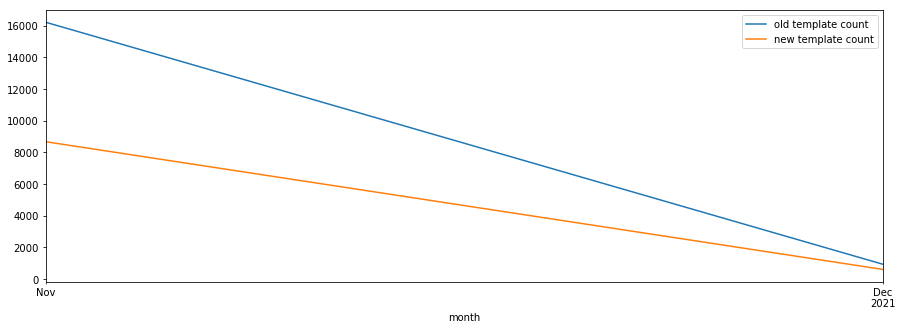

In [231]:
monthly_medians.plot(x='month', y=['old template count', 'new template count'], figsize=(15,5))

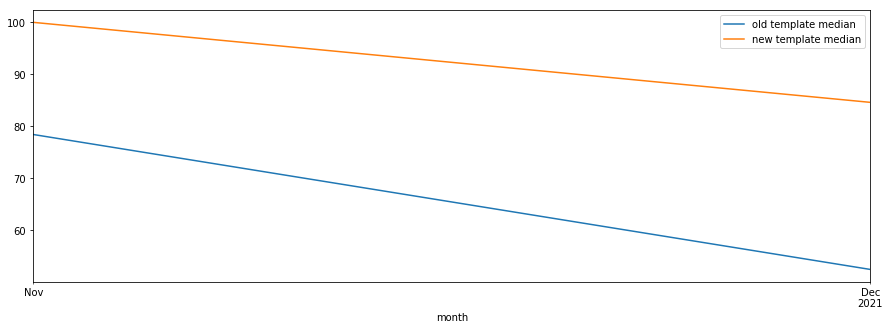

In [232]:
monthly_medians.plot(x='month', y=['old template median', 'new template median'], figsize=(15,5))

In [233]:
trans_monthly_sums = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [234]:
monthly_sums = trans_monthly_sums.pivot(index='month', columns='is new template', values=['amount']).reset_index()
monthly_sums.columns = ['month', 'old template vol', 'new template vol']

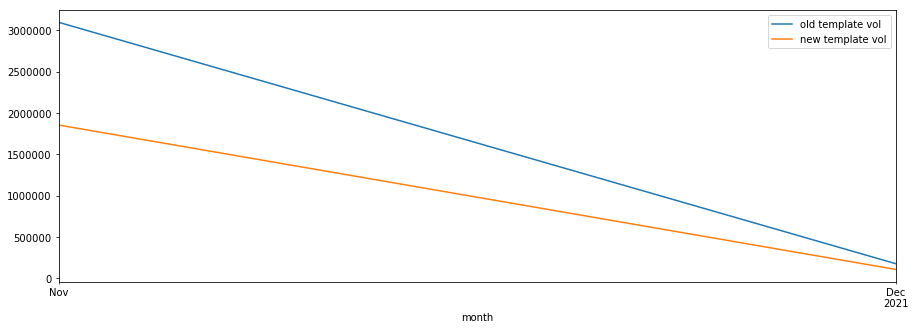

In [235]:
monthly_sums.plot(x='month', figsize=(15,5))

In [236]:
trans_monthly_counts = trans.groupby(['month', 'is new template', 'is_recurring'])['id'].nunique().reset_index()
trans_monthly_counts = trans_monthly_counts.pivot(index='month', columns=['is new template', 'is_recurring'], values='id').reset_index()
trans_monthly_counts.columns = ['month', 'one time old template', 
                                'recurring old template', 'one time new template',
                                'recurring new template']

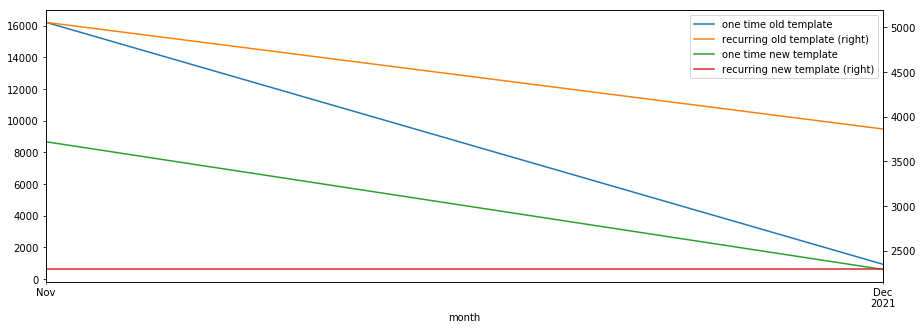

In [237]:
secondary_ys = ['recurring old template', 'recurring new template']
trans_monthly_counts.plot(x='month', secondary_y=secondary_ys, figsize=(15,5))

#### monthly onetime/recurring ratio

In [238]:
trans['month'] = trans['date'].dt.to_period('m')
monthly_ratios = trans.groupby(['month', 'is_recurring', 'is new template'])['id'].nunique().reset_index()

In [239]:
monthly_ratios = monthly_ratios.pivot(index='month', columns=['is_recurring', 'is new template'], values='id').reset_index()
monthly_ratios.columns = ['month', 'onetime old template', 'onetime new template', 'recurring old template', 'recurring new template']
monthly_ratios['new template ratio'] = monthly_ratios['onetime new template'] / monthly_ratios['recurring new template']
monthly_ratios['old template ratio'] = monthly_ratios['onetime old template'] / monthly_ratios['recurring old template']

In [240]:
monthly_ratios.tail(12)

,month,onetime old template,onetime new template,recurring old template,recurring new template,new template ratio,old template ratio
0,2021-11,16200,8660,5053,2291,3.780009,3.206016
1,2021-12,923,598,3861,2291,0.261021,0.239057


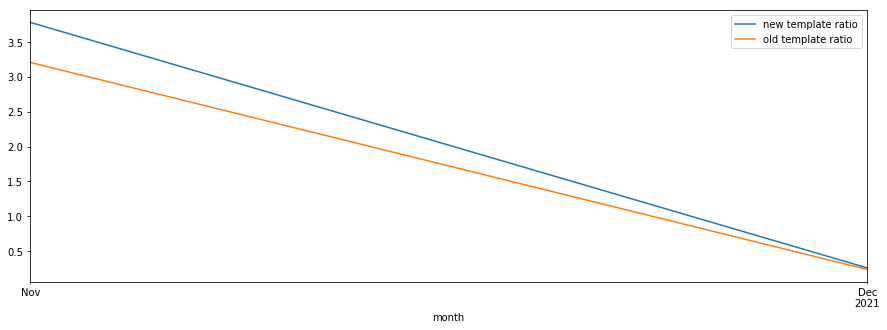

In [241]:
monthly_ratios[['month', 'new template ratio', 'old template ratio']].plot(x='month', figsize=(15,5))

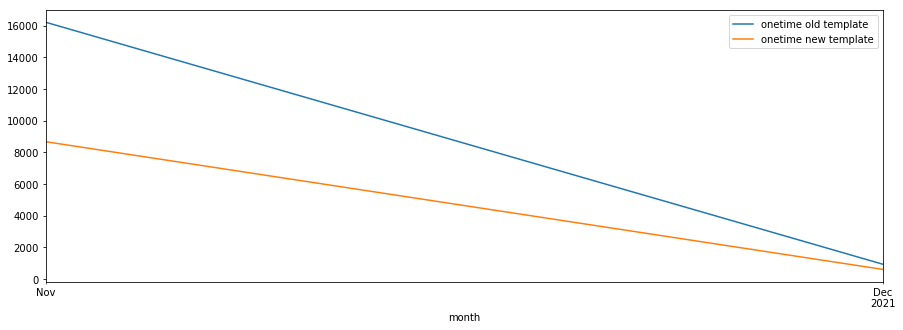

In [242]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', figsize=(15,5))

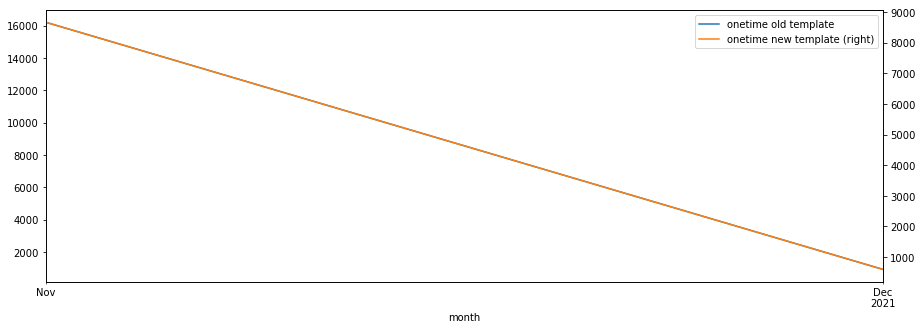

In [243]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', secondary_y='onetime new template', figsize=(15,5))

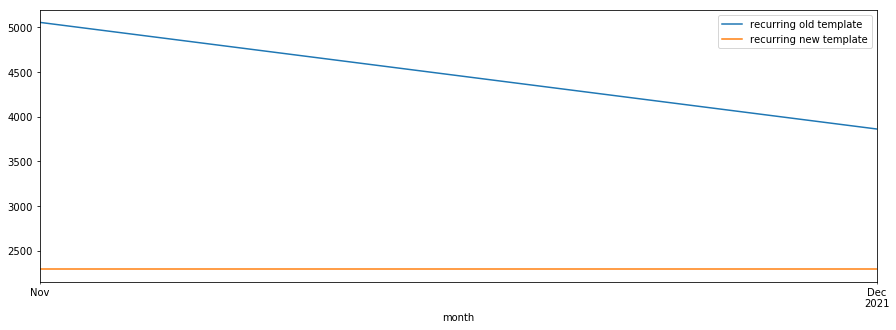

In [244]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', figsize=(15,5))

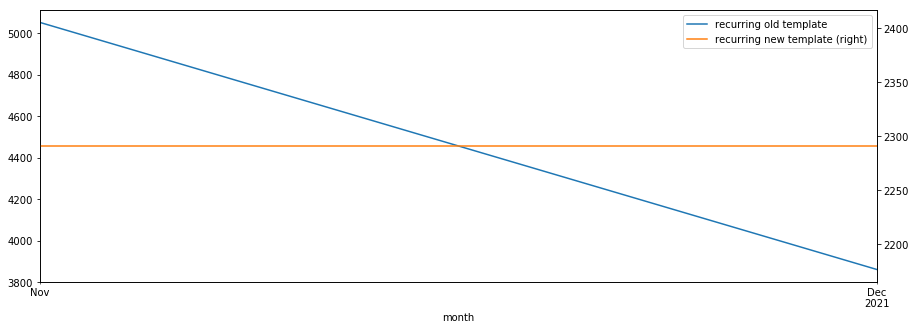

In [245]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', secondary_y='recurring new template', figsize=(15,5))

- one time / recurring over time, one time, recurring, recurring all vs originating
- over time, table

In [246]:
daily_onetime = trans[~trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
daily_onetime.columns = ['date', 'old template onetime', 'new template onetime']

daily_rec_originating = trans[trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_originating = daily_rec_originating.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_originating.columns = ['date', 'old template rec origin', 'new template rec origin']

daily_rec_all = trans_all[trans_all['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_all = daily_rec_all.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_all.columns = ['date', 'old template rec all', 'new template rec all']

daily_trans = daily_onetime.merge(daily_rec_originating, on='date', how='outer').merge(daily_rec_all, on='date', how='outer')

In [247]:
daily_trans.tail(3)

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all
0,2021-11-30,16200,8660,5053,2291,5444,2530
1,2021-12-01,923,598,3861,2291,3894,2317


In [248]:
daily_trans['new template onetime / rec origin'] = daily_trans['new template onetime'] / daily_trans['new template rec origin']
daily_trans['new template onetime / rec all'] = daily_trans['new template onetime'] / daily_trans['new template rec all']

daily_trans['old template onetime / rec origin'] = daily_trans['old template onetime'] / daily_trans['old template rec origin']
daily_trans['old template onetime / rec all'] = daily_trans['old template onetime'] / daily_trans['old template rec all']

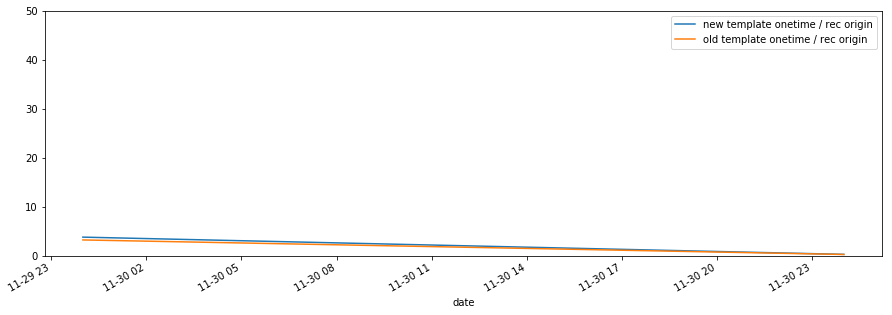

In [249]:
cols = ['date', 'new template onetime / rec origin', 
        'old template onetime / rec origin']
daily_trans[cols].plot(x='date', ylim=(0,50), figsize=(15,5))

In [250]:
cols = ['old template onetime', 'new template onetime',
       'old template rec origin', 'new template rec origin',
       'old template rec all', 'new template rec all']
monthly_trans = daily_trans.groupby(daily_trans['date'].dt.to_period('m'))[cols].sum().reset_index()

In [251]:
monthly_trans['new template onetime / rec origin'] = monthly_trans['new template onetime'] / monthly_trans['new template rec origin']
monthly_trans['new template onetime / rec all'] = monthly_trans['new template onetime'] / monthly_trans['new template rec all']

monthly_trans['old template onetime / rec origin'] = monthly_trans['old template onetime'] / monthly_trans['old template rec origin']
monthly_trans['old template onetime / rec all'] = monthly_trans['old template onetime'] / monthly_trans['old template rec all']

In [252]:
monthly_trans

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all,new template onetime / rec origin,new template onetime / rec all,old template onetime / rec origin,old template onetime / rec all
0,2021-11,16200,8660,5053,2291,5444,2530,3.780009,3.422925,3.206016,2.975753
1,2021-12,923,598,3861,2291,3894,2317,0.261021,0.258092,0.239057,0.237031


In [253]:
#monthly_trans.to_csv("monthly_onetime_rec.csv", index=False)

#### monthly volumes

In [254]:
these_trans = trans[(trans['is new template'])&(trans['month']=='2021-07')]

print("07/2021 new template transactions: {:,}".format(len(these_trans)))
print("\tunique transactions: {:,}".format(these_trans['id'].nunique()))
print()

these_trans.sort_values('amount').tail()

07/2021 new template transactions: 0
	unique transactions: 0



,id,date,form,amount,recurring,source,useragent,is_recurring,is new template,is embed,month


In [255]:
monthly_volume = trans.groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [256]:
monthly_vol = monthly_volume.pivot(index='month', columns='is new template', values='amount').reset_index()
monthly_vol.columns = ['month', 'old template volume', 'new template volume']
monthly_vol.tail()

,month,old template volume,new template volume
0,2021-11,3365214.87,2004563.61
1,2021-12,664539.58,263819.73


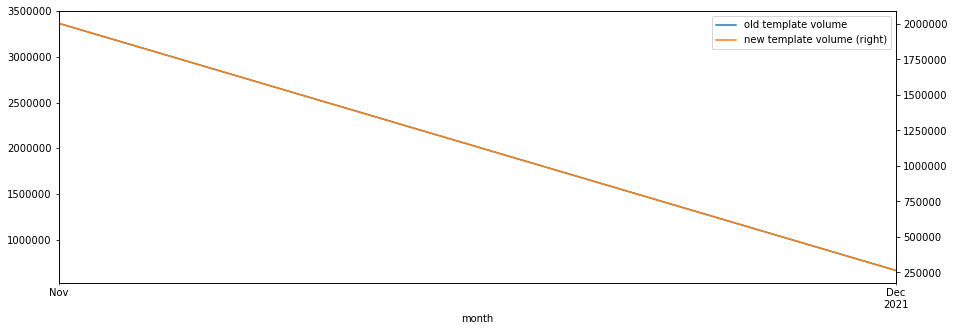

In [257]:
monthly_vol.plot(x='month', secondary_y='new template volume', figsize=(15,5))

#### form sample sizes

In [258]:
print("Dailies:")
print("\tnew template: {:,}".format(len(dailies[dailies['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(dailies[~dailies['is new template']]['form'].unique())))
print()

print("Transactions:")
print("\tnew template: {:,}".format(len(trans[trans['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(trans[~trans['is new template']]['form'].unique())))

Dailies:
	new template: 1,020
	old template: 2,641

Transactions:
	new template: 1,599
	old template: 2,059


In [259]:
daily_forms = dailies.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_forms = daily_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_forms.columns = ['date', 'old template', 'new template']

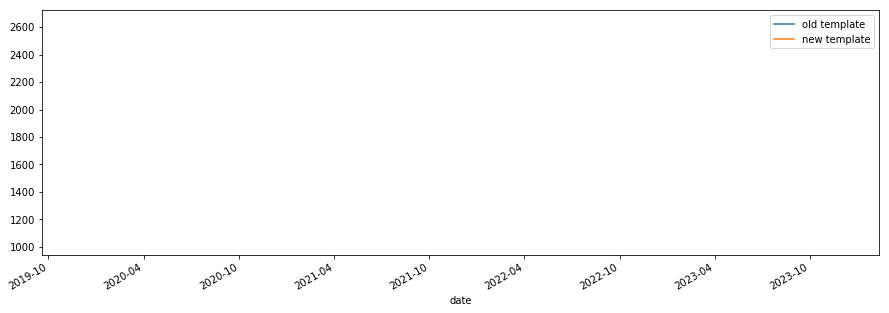

In [260]:
daily_forms.plot(x='date', figsize=(15,5))

In [261]:
daily_trans_forms = trans.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_trans_forms = daily_trans_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_trans_forms.columns = ['date', 'old template', 'new template']

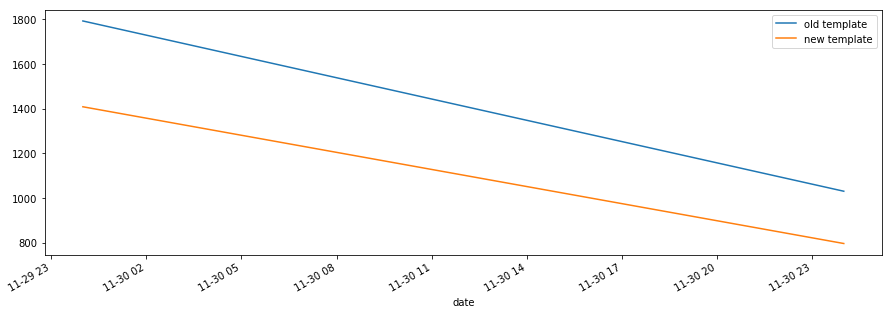

In [262]:
daily_trans_forms.plot(x='date', figsize=(15,5))

#### trans vs dailies one time

In [263]:
daily_onetime = dailies.groupby(['date', 'is new template'])['trans_count_onetime'].sum().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='trans_count_onetime').reset_index()
daily_onetime.columns = ['date', 'old template', 'new template']

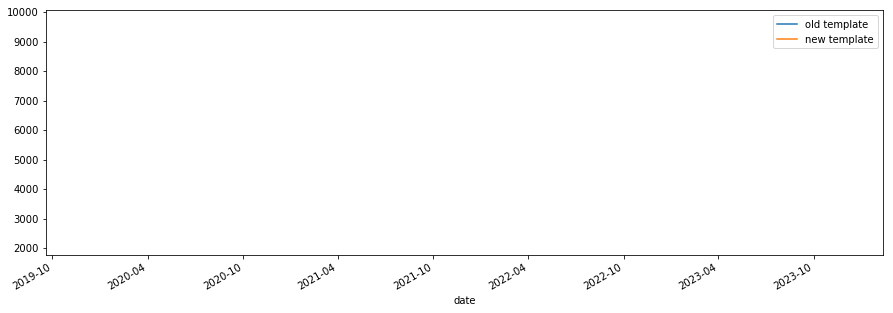

In [264]:
daily_onetime.plot(x='date', figsize=(15,5))

In [265]:
trans_onetime = trans[trans['recurring']==0].groupby(['date', 'is new template'])['id'].nunique().reset_index()
trans_onetime = trans_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
trans_onetime.columns = ['date', 'old template', 'new template']

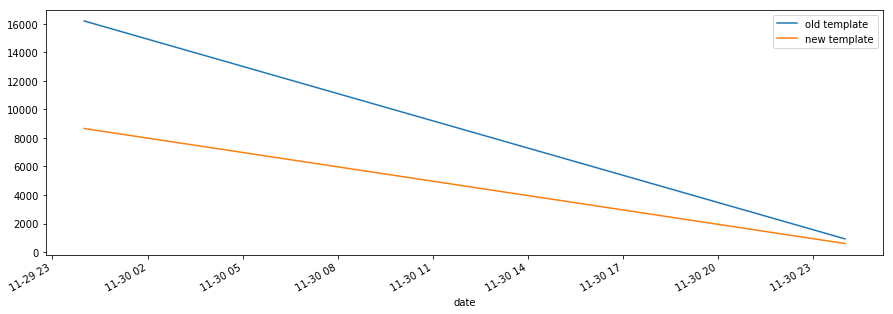

In [266]:
trans_onetime.plot(x='date', figsize=(15,5))

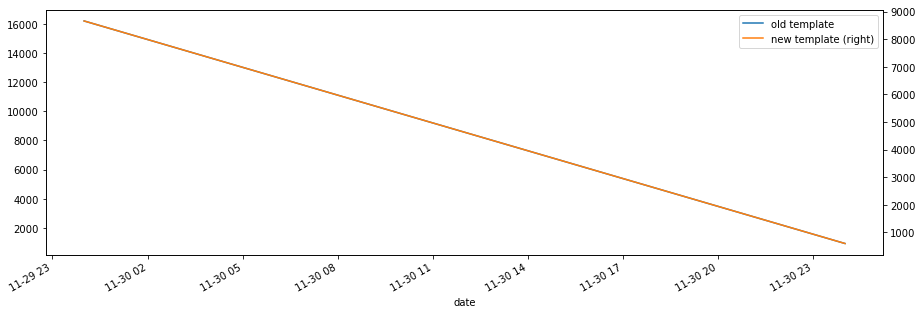

In [267]:
trans_onetime.plot(x='date', secondary_y='new template', figsize=(15,5))

In [268]:
iso_trans = trans[(trans['date']=='2021-02-25')&(trans['is new template'])]
iso_trans.groupby('form')['amount'].sum().reset_index().sort_values('amount').tail()

,form,amount


#### active forms per month

last 90 days, new forms represent 40% by sample size but 6% of the pageviews 

In [269]:
forms_by_month_trans = trans.groupby(['month', 'is new template'])['form'].nunique().reset_index()
forms_by_month_trans = forms_by_month_trans.pivot(index='month', columns='is new template', values='form').reset_index()
forms_by_month_trans.columns = ['month', 'old template forms', 'new template forms']
forms_by_month_trans

,month,old template forms,new template forms
0,2021-11,1792,1408
1,2021-12,1030,796


In [270]:
dailies['month'] = dailies['date'].dt.to_period('m')
dailies_traffic_by_month = dailies.groupby(['month', 'is new template'])['views'].sum().reset_index()
dailies_traffic_by_month = dailies_traffic_by_month.pivot(index='month', columns='is new template', values='views').reset_index()
dailies_traffic_by_month.columns = ['month', 'old template', 'new template']

dailies_traffic_by_month['total'] = dailies_traffic_by_month['old template'] + dailies_traffic_by_month['new template']
dailies_traffic_by_month['new template percentage'] = dailies_traffic_by_month['new template'] / dailies_traffic_by_month['total']
dailies_traffic_by_month

,month,old template,new template,total,new template percentage
0,2021-11,146291.0,33832.0,180123.0,0.187827


In [271]:
#dailies.to_csv("dailies.csv", index=False)

# report

In [272]:
#dailies = pd.read_csv("dailies.csv")

In [273]:
def report(df, df_all_trans):
    df.replace(np.inf, np.nan, inplace=True)
    return {
        'form sample size': len(df_all_trans['form'].unique().tolist()),
        'transactions': df_all_trans[df_all_trans['recurring']==0]['id'].nunique() + df['trans_count_recurring'].sum(),
        'transactions per form': df_all_trans.groupby('form')['id'].count().mean(),
        'conversion': df['conversion'].mean(),
        'conversion onetime': df['conversion_onetime'].mean(),
        'conversion recurring': df['conversion_recurring'].mean(),
        'mean transaction onetime': df['trans_vol_onetime'].sum() / df['trans_count_onetime'].sum(),
        'median transaction onetime': df_all_trans[~df_all_trans['is_recurring']]['amount'].median(),
        'mean transaction recurring': df['trans_vol_recurring'].sum() / df['trans_count_recurring'].sum(),
        'median transaction recurring': df_all_trans[df_all_trans['is_recurring']]['amount'].median(),
        'onetime/recurring': df['trans_count_onetime'].sum() / df['trans_count_recurring'].sum(),
        'pageviews': df['views'].sum(),
        'bounce rate': df['bounces'].sum() / df['views'].sum(),
        'transactions one time': len(df_all_trans[~df_all_trans['is_recurring']]),
        'transactions origin recurring': df['trans_count_recurring'].sum(), 
        'transactions all recurring': len(df_all_trans[df_all_trans['is_recurring']])
    }

### new vs old

In [274]:
data_all = {
    'all': report(dailies, trans_all),
    'new template': report(dailies[dailies['is new template']], trans_all[trans_all['is new template']]),
    'old template': report(dailies[~dailies['is new template']], trans_all[~trans_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [275]:
print("{:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2021-11-30 +


,new template,old template
form sample size,1599.000000,2059.000000
transactions,9624.000000,18388.000000
transactions per form,8.821138,12.851384
conversion,0.112763,0.057239
conversion onetime,0.090582,0.046547
conversion recurring,0.022180,0.010692
mean transaction onetime,199.242141,180.862392
median transaction onetime,100.000000,78.000000
mean transaction recurring,61.070710,48.287202
median transaction recurring,30.000000,25.000000


In [276]:
trans[['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,78.0
1,False,True,100.0
2,True,False,25.0
3,True,True,30.0


In [277]:
trans[['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].mean().reset_index()

,is_recurring,is new template,amount
0,False,False,191.005344
1,False,True,211.575199
2,True,False,85.166024
3,True,True,67.573145


### all past 90 days

In [278]:
ninety_days_ago = dailies['date'].max() - datetime.timedelta(90)
last_90 = dailies[dailies['date']>=ninety_days_ago]
last_90_all = trans_all[trans_all['date']>=ninety_days_ago]

In [279]:
last_90['date'].min(), last_90_all['date'].min()

(Timestamp('2021-11-30 00:00:00'), Timestamp('2021-11-30 00:00:00'))

In [280]:
data_last_90 = {
    'all': report(last_90, last_90_all),
    'new template': report(last_90[last_90['is new template']], last_90_all[last_90_all['is new template']]),
    'old template': report(last_90[~last_90['is new template']], last_90_all[~last_90_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [281]:
print("{:%Y-%m-%d} +".format(last_90['date'].min()))
df = pd.DataFrame(data_last_90)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2021-11-30 +


,new template,old template
form sample size,1599.000000,2059.000000
transactions,9624.000000,18388.000000
transactions per form,8.821138,12.851384
conversion,0.112763,0.057239
conversion onetime,0.090582,0.046547
conversion recurring,0.022180,0.010692
mean transaction onetime,199.242141,180.862392
median transaction onetime,100.000000,78.000000
mean transaction recurring,61.070710,48.287202
median transaction recurring,30.000000,25.000000


In [282]:
trans_last_90 = trans[trans['date']>=ninety_days_ago]
trans_last_90[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,78.0
1,False,True,100.0
2,True,False,25.0
3,True,True,30.0


### all past 30 days

In [283]:
thirty_days_ago = dailies['date'].max() - datetime.timedelta(30)
last_30 = dailies[dailies['date']>=thirty_days_ago]
last_30_all = trans_all[trans_all['date']>=thirty_days_ago]

In [284]:
last_30['date'].min(), last_30['date'].max()

(Timestamp('2021-11-30 00:00:00'), Timestamp('2021-11-30 00:00:00'))

In [285]:
last_30['date'].min(), last_30_all['date'].min()

(Timestamp('2021-11-30 00:00:00'), Timestamp('2021-11-30 00:00:00'))

In [286]:
data_last_30 = {
    'all': report(last_30, last_30_all),
    'new template': report(last_30[last_30['is new template']], last_30_all[last_30_all['is new template']]),
    'old template': report(last_30[~last_30['is new template']], last_30_all[~last_30_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [287]:
print("{:%Y-%m-%d} +".format(last_30['date'].min()))
df = pd.DataFrame(data_last_30)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2021-11-30 +


,new template,old template
form sample size,1599.000000,2059.000000
transactions,9624.000000,18388.000000
transactions per form,8.821138,12.851384
conversion,0.112763,0.057239
conversion onetime,0.090582,0.046547
conversion recurring,0.022180,0.010692
mean transaction onetime,199.242141,180.862392
median transaction onetime,100.000000,78.000000
mean transaction recurring,61.070710,48.287202
median transaction recurring,30.000000,25.000000


In [288]:
trans_last_30 = trans[trans['date']>=thirty_days_ago]
trans_last_30[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,78.0
1,False,True,100.0
2,True,False,25.0
3,True,True,30.0


### embeds

##### all embeds

In [289]:
dailies.groupby('is embed')['conversion'].mean()

is embed
False    0.049852
True     0.131170
Name: conversion, dtype: float64

In [290]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[dailies['is embed']], trans_all[trans_all['is embed']]),
    'not embed': report(dailies[~dailies['is embed']], trans_all[~trans_all['is embed']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [291]:
print("Embeds {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds 2021-11-30 +


,embed,not embed
form sample size,1977.000000,1680.000000
transactions,13466.000000,14546.000000
transactions per form,9.899848,12.496429
conversion,0.131170,0.049852
conversion onetime,0.104859,0.040814
conversion recurring,0.026311,0.009038
mean transaction onetime,219.173458,172.311041
median transaction onetime,100.000000,60.000000
mean transaction recurring,59.561592,47.546021
median transaction recurring,28.500000,25.000000


##### new template embeds

In [292]:
dailies[dailies['is new template']].groupby('is embed')['conversion'].mean()

is embed
False    0.080920
True     0.151682
Name: conversion, dtype: float64

In [293]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[(dailies['is embed'])&(dailies['is new template'])], trans_all[(trans_all['is embed'])&(trans_all['is new template'])]),
    'not embed': report(dailies[(~dailies['is embed'])&(dailies['is new template'])], trans_all[(~trans_all['is embed'])&(trans_all['is new template'])])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [294]:
print("Embeds (new template) {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds (new template) 2021-11-30 +


,embed,not embed
form sample size,1048.000000,551.000000
transactions,6907.000000,2717.000000
transactions per form,9.701336,7.147005
conversion,0.151682,0.080920
conversion onetime,0.116890,0.069058
conversion recurring,0.034792,0.011862
mean transaction onetime,212.316754,179.102268
median transaction onetime,100.000000,79.375000
mean transaction recurring,61.772744,60.071126
median transaction recurring,30.000000,30.000000


In [295]:
trans[trans['is new template']][['amount', 'is_recurring', 'is embed']].groupby(['is_recurring', 'is embed'])['amount'].median().reset_index()

,is_recurring,is embed,amount
0,False,False,79.375
1,False,True,100.000
2,True,False,30.300
3,True,True,30.000


### Forms w/ trans new & old

In [296]:
new_template_forms = dailies[dailies['is new template']]['form'].unique().tolist()
old_template_overlap = dailies[(~dailies['is new template'])&(dailies['form'].isin(new_template_forms))]['form'].unique().tolist()

print("all forms: {}".format(len(dailies['form'].unique())))
print("new template forms: {}".format(len(new_template_forms)))
print("old template overlap forms: {}".format(len(old_template_overlap)))

all forms: 3661
new template forms: 1020
old template overlap forms: 0


In [297]:
dailies_overlap = dailies[dailies['form'].isin(old_template_overlap)]
trans_all_overlap = trans_all[trans_all['form'].isin(old_template_overlap)]

In [298]:
data_all = {
    'all': report(dailies_overlap, trans_all_overlap),
    'new template': report(dailies_overlap[dailies_overlap['is new template']], trans_all_overlap[trans_all_overlap['is new template']]),
    'old template': report(dailies_overlap[~dailies_overlap['is new template']], trans_all_overlap[~trans_all_overlap['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [299]:
print("Forms w/ transaction in new & old {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Forms w/ transaction in new & old 2021-11-30 +


,new template,old template
form sample size,0.0,0.0
transactions,0.0,0.0
transactions per form,NaN,NaN
conversion,NaN,NaN
conversion onetime,NaN,NaN
conversion recurring,NaN,NaN
mean transaction onetime,NaN,NaN
median transaction onetime,NaN,NaN
mean transaction recurring,NaN,NaN
median transaction recurring,NaN,NaN


In [300]:
trans[trans['form'].isin(old_template_overlap)][['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
